## Generating solar scenarios using PGscen ##

In this notebook we will use PGscen to create a scenarios for photovoltaic generator output across the NYISO system. The output generated here can also be created using the ```pgscen-ny-solar``` command line tool.

As in the case of the load and wind asset scenarios, we begin by creating the scenario generation parameters and setting up the input datasets.

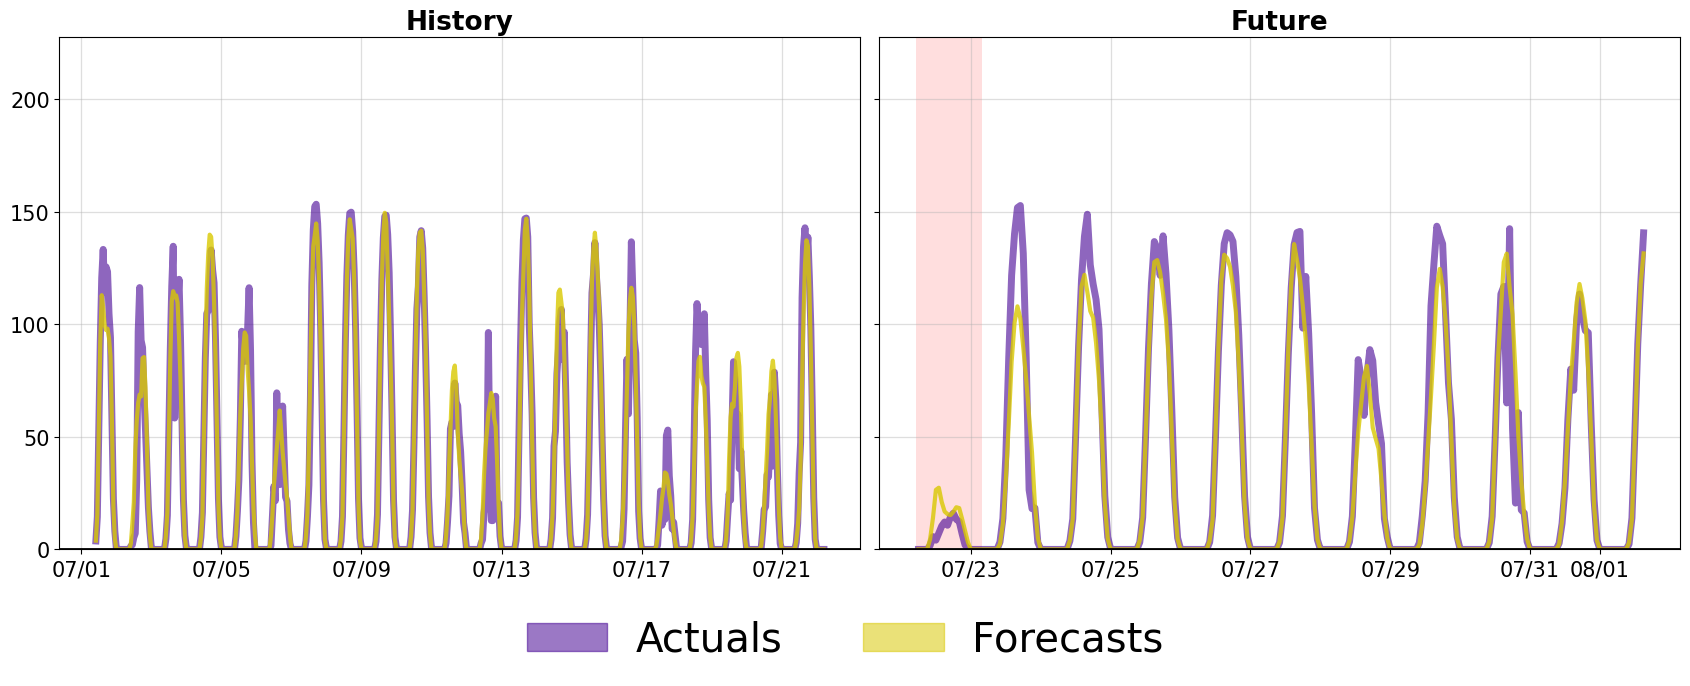

In [1]:
from pathlib import Path
import pandas as pd
from pgscen.utils.data_utils import (
    load_ny_solar_data, split_actuals_hist_future, split_forecasts_hist_future)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 11]
from IPython.display import display

start_date = '2019-07-22'
cur_path = Path("nyiso_day_ahead_solar.ipynb").parent.resolve()
data_dir = Path(cur_path, "..", "..", "data").resolve()

scenario_count = 1000
scen_start_time = pd.to_datetime(' '.join([start_date, "06:00:00"]), utc=True)
scen_timesteps = pd.date_range(start=scen_start_time, periods=24, freq='H')

(solar_site_actual_df, solar_site_forecast_df,
     solar_meta_df) = load_ny_solar_data()

(solar_site_actual_hists,
     solar_site_actual_futures) = split_actuals_hist_future(
            solar_site_actual_df, scen_timesteps)

(solar_site_forecast_hists,
     solar_site_forecast_futures) = split_forecasts_hist_future(
            solar_site_forecast_df, scen_timesteps)

fig, (hist_ax, future_ax) = plt.subplots(figsize=(17, 6),
                                         nrows=1, ncols=2, sharey=True)

title_args = dict(weight='semibold', size=19)
actual_clr, fcst_clr = "#430093", "#D9C800"
plt_asset = 'Alder Creek Solar'

hist_ax.set_title("History", **title_args)
hist_ax.plot(solar_site_actual_hists[plt_asset][-500:],
             c=actual_clr, lw=5, alpha=0.6)
hist_ax.plot(solar_site_forecast_hists['Forecast_time'][-500:],
             solar_site_forecast_hists[plt_asset][-500:],
             c=fcst_clr, lw=3, alpha=0.8)
hist_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

future_ax.set_title("Future", **title_args)
future_ax.plot(solar_site_actual_futures[plt_asset][:250],
               c=actual_clr, lw=5, alpha=0.6)
future_ax.plot(solar_site_forecast_futures['Forecast_time'][:250],
               solar_site_forecast_futures[plt_asset][:250],
               c=fcst_clr, lw=3, alpha=0.8)
future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

future_ax.fill_between(solar_site_actual_futures.index[:24] - pd.Timedelta(hours=1),
                       solar_site_actual_futures[plt_asset][:24].min() - 700,
                       solar_site_actual_futures[plt_asset][:24].max() + 700,
                       facecolor='red', edgecolor='none', alpha=0.13)

for ax in [hist_ax, future_ax]:
    ax.tick_params(which='both', labelsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)

    ax.set_ylim((0, solar_meta_df.AC_capacity_MW[solar_meta_df.site_ids
                                                 == plt_asset].values[0] * 1.11))

lgnd_ptchs = [Patch(color=actual_clr, alpha=0.53, label="Actuals"),
              Patch(color=fcst_clr, alpha=0.53, label="Forecasts")]

_ = fig.legend(handles=lgnd_ptchs, frameon=False, fontsize=29, ncol=2, loc=8,
               bbox_to_anchor=(0.5, -0.17), handletextpad=0.7)
fig.tight_layout(w_pad=1)

Like the wind scenario engine, the solar engine creates a unique regularization penalty for each pair of generators in the GEMINI model based on the physical distance between them, which is calculated using generator metadata. 

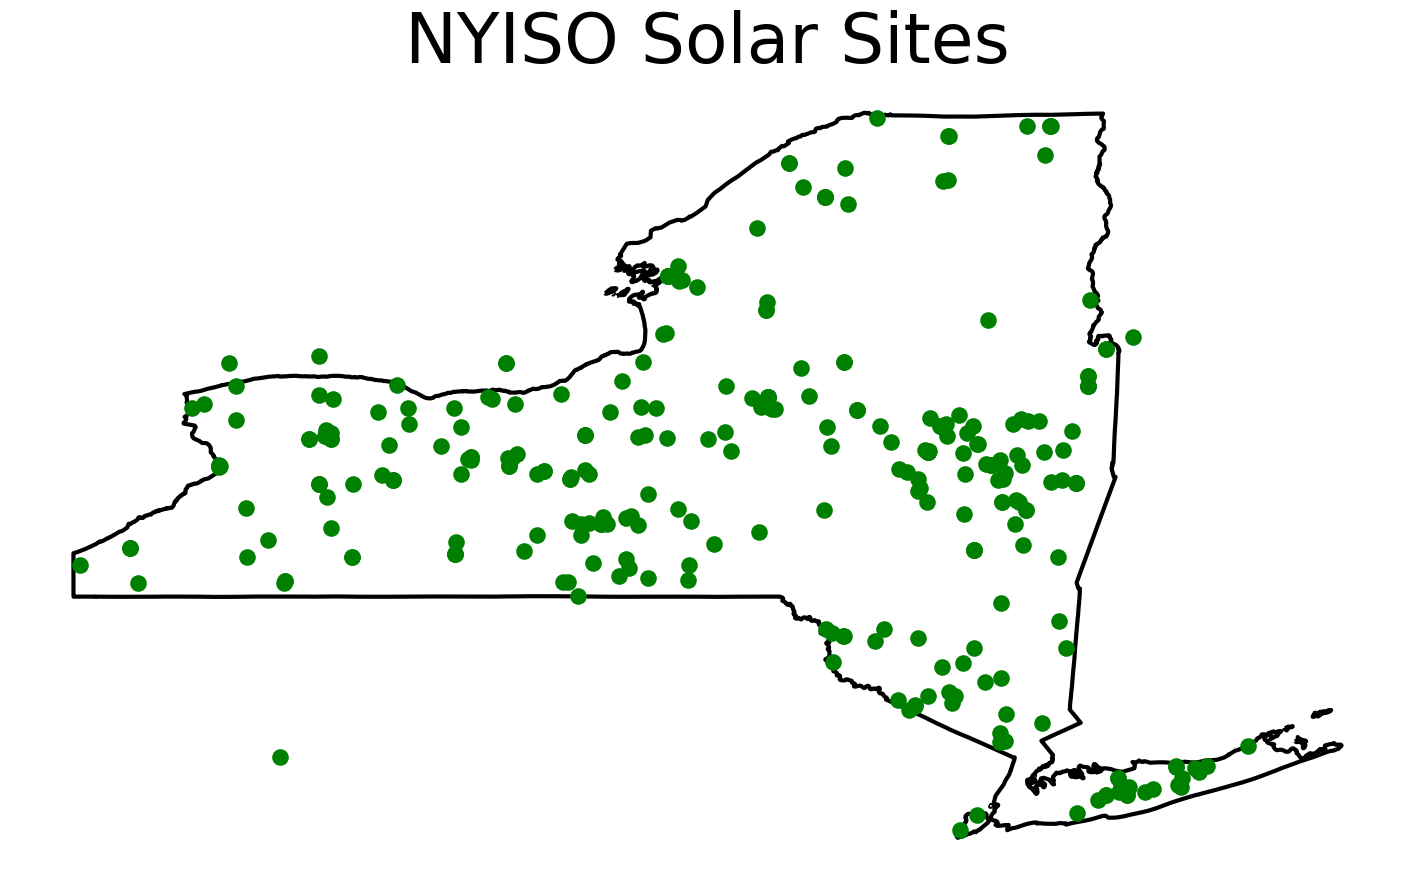

In [2]:
from pgscen.pca import PCAGeminiEngine
import geopandas as gpd
from shapely.geometry import Point


se = PCAGeminiEngine(solar_site_actual_hists, solar_site_forecast_hists,
                       scen_start_time, solar_meta_df, us_state = 'New York')

gdf = gpd.GeoDataFrame(
    se.meta_df, geometry=[Point(xy) for xy in zip(se.meta_df['longitude'],
                                                  se.meta_df['latitude'])]
    )

tx = gpd.read_file(Path(data_dir, 'Map', 'ny.shp.zip'))
ax = tx.plot(facecolor="none", edgecolor='black', linewidth=3, figsize=(18, 18))
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=143, c='green')
plt.title('NYISO Solar Sites', fontsize=50)
_ = ax.axis('off')

dist = se.asset_distance().values
se.fit(asset_rho=dist / (1 * dist.max()), 
       pca_comp_rho=1e-1,
       num_of_components=0.9,
      )

Again, our fitted model parameters should therefore reflect in part the physical topology of the ERCOT power grid.

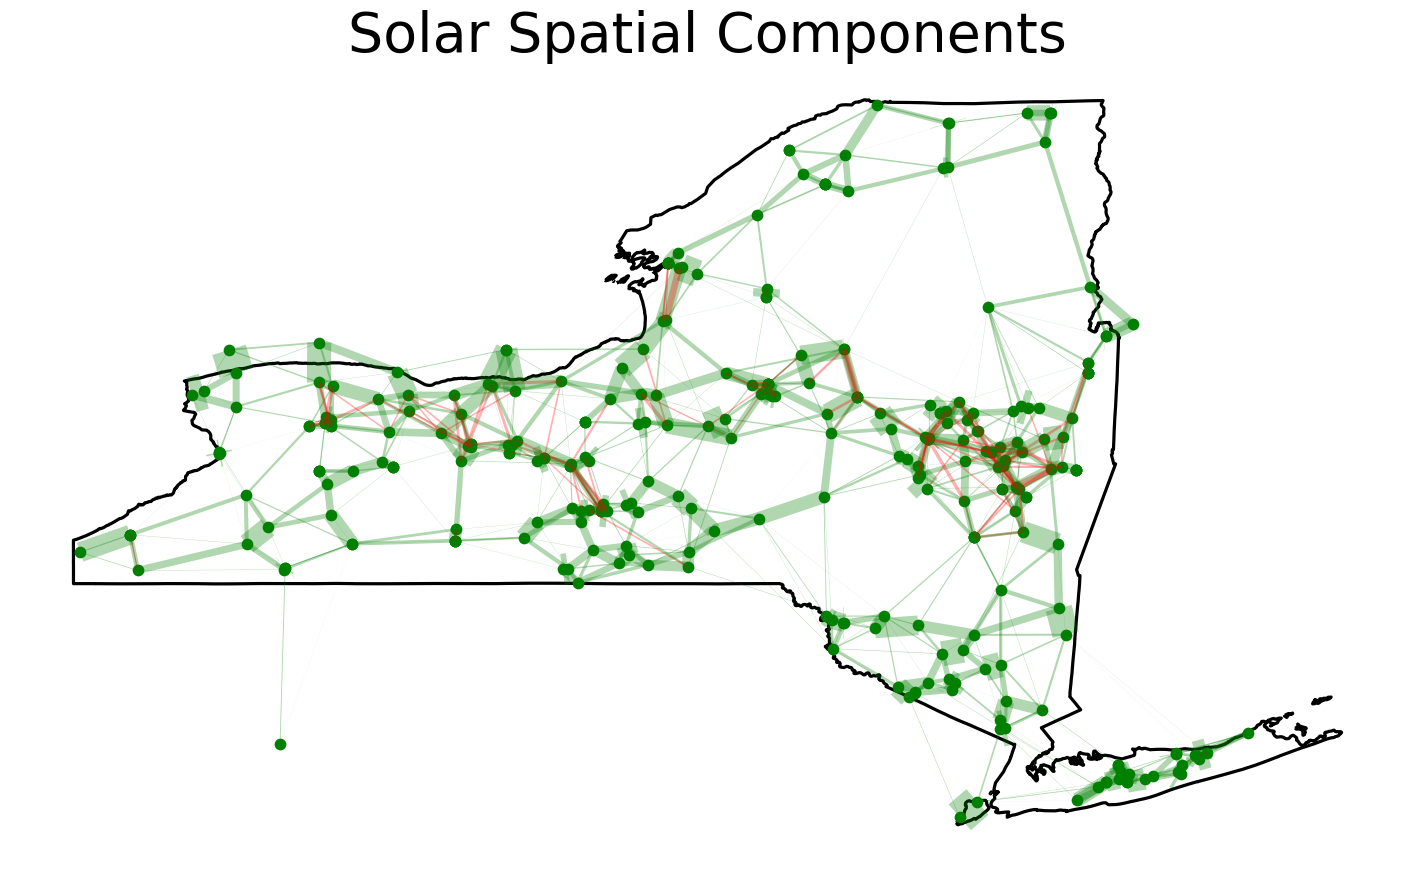

In [5]:
import numpy as np
from itertools import combinations as combn
from shapely.geometry import LineString


asset_cov = se.model.asset_cov
prec_mat = np.linalg.inv(asset_cov)
pcor_mat = -prec_mat / np.sqrt(np.outer(np.diag(prec_mat), np.diag(prec_mat)))

cnct_dict = {
    (asset1, asset2): {
        'geometry': LineString([gdf.geometry[asset1], gdf.geometry[asset2]]),
        'pcor_val': pcor_mat[i, j]
        }
    for (i, asset1), (j, asset2) in combn(enumerate(asset_cov.index), 2)
    if np.abs(pcor_mat[i, j]) >= 0.01
    }

edges_gdf = gpd.GeoDataFrame(cnct_dict).transpose()
edges_gdf = edges_gdf.set_geometry('geometry')
ax = tx.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')

sign_vec = ['green' if val > 0 else "red" for val in edges_gdf.pcor_val]
edges_gdf.plot(ax=ax, color=sign_vec,
               linewidth=(edges_gdf.pcor_val - 0.02) * 33, alpha=0.31)

ax.set_title('Solar Spatial Components', fontsize=40)
_ = ax.axis('off')

Like wind, scenario generation can also take a few minutes of runtime.

In [6]:
se.create_scenario(scenario_count, solar_site_forecast_futures)

In [7]:
from ipywidgets import interact, Dropdown
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_solar_scenarios(solar_site):
    ax = tx.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)
    gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')

    cntr_x, cntr_y = se.meta_df.longitude.mean(), se.meta_df.latitude.mean()
    site_x, site_y = se.meta_df.loc[solar_site, ['longitude', 'latitude']]
    xdiff, ydiff = site_x - cntr_x, site_y - cntr_y

    cntr_dist = (xdiff ** 2 + ydiff ** 2) ** 0.5
    site_cos, site_sin = xdiff / cntr_dist, ydiff / cntr_dist
    scen_x, scen_y = cntr_x + 8.5 * site_cos, cntr_y + 8.5 * site_sin

    scen_size = 7.5, 4
    scen_bbox = (scen_x - scen_size[0] / 2, scen_y - scen_size[1] / 2,
                 scen_size[0], scen_size[1])

    scen_ax = inset_axes(ax, width='100%', height='100%',
                         bbox_to_anchor=scen_bbox, bbox_transform=ax.transData,
                         loc=10, borderpad=0)
    
    ax.plot([site_x + 0 * site_cos, scen_x - 3.8 * site_cos],
            [site_y + 0 * site_sin, scen_y - 2 * site_sin],
            linewidth=4.3, c='black', alpha=0.53, linestyle='dotted')
    
    for i in range(scenario_count):
        scen_ax.plot(se.scenarios['solar'].iloc[i][solar_site],
                     c='black', alpha=0.13, lw=0.2)

    plt_fcst = se.forecasts['solar'][solar_site]
    scen_ax.plot(plt_fcst, c=fcst_clr, alpha=0.47, lw=4.1)
    scen_ax.plot(solar_site_actual_futures.loc[plt_fcst.index, solar_site],
                 c=actual_clr, alpha=0.47, lw=4.1)

    scen_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    scen_ax.tick_params(axis='both', labelsize=17)
    scen_ax.grid(linewidth=0.9, alpha=0.41)
    scen_ax.set_ylim((0, scen_ax.get_ylim()[1]))
    
    quant_df = se.scenarios['solar'][solar_site].quantile([0.25, 0.75])
    scen_ax.fill_between(quant_df.columns, quant_df.iloc[0], quant_df.iloc[1],
                         color='red', alpha=0.31)

    lgnd_ptchs = [Patch(color='black', alpha=0.23, label="Scenarios"),
                  Patch(color='red', alpha=0.41, label="Interquartile Range"),
                  Patch(color=fcst_clr, alpha=0.81, label="Forecast"),
                  Patch(color=actual_clr, alpha=0.81, label="Actual")]

    _ = scen_ax.legend(handles=lgnd_ptchs, frameon=False,
                       fontsize=11, ncol=2, handletextpad=0.5)

    ax.axis('off')

    
w = Dropdown(options=se.asset_list, description="Scenarios for generator:",
             layout={'align_self': 'center'}, style={'description_width': 'initial'},
             disabled=False)
_ = interact(plot_solar_scenarios, solar_site=w)

interactive(children=(Dropdown(description='Scenarios for generator:', layout=Layout(align_self='center'), opt…